<a href="https://colab.research.google.com/github/luqmanafiq/AI-and-ML-LOL/blob/main/AI_and_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import time
import pandas as pd
from google.colab import drive

# Mount Google Drive for persistent storage (optional, recommended for Colab)
drive.mount('/content/drive')

# Riot API Key and regions with platform and regional hosts (only LEC, LCK, and LTAN)
API_KEY = 'RGAPI-76aaf440-261b-4fc8-9362-60e84fcd0aa7'
REGIONS = {
    'KR': {'platform': 'kr', 'region': 'asia'},
    'EUROPE': {'platform': 'euw1', 'region': 'europe'},
    'NA': {'platform': 'la1', 'region': 'americas'}
}
TIERS = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
DIVISIONS = ['IV', 'III', 'II', 'I']
TARGET_MATCHES = 10000  # Total matches to collect across selected regions
MATCHES_PER_REGION = TARGET_MATCHES // len(REGIONS)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to fetch players for a given tier
def get_players_by_tier(region_name, tier, division=None, api_key=API_KEY):
    platform = REGIONS[region_name]['platform']
    summoner_ids = []
    if tier in ['CHALLENGER', 'GRANDMASTER', 'MASTER']:
        endpoint = {
            'CHALLENGER': 'challengerleagues',
            'GRANDMASTER': 'grandmasterleagues',
            'MASTER': 'masterleagues'
        }[tier]
        url = f"https://{platform}.api.riotgames.com/lol/league/v4/{endpoint}/by-queue/RANKED_SOLO_5x5?api_key={api_key}"
    else:
        url = f"https://{platform}.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?api_key={api_key}"

    while True:
        resp = requests.get(url)
        if resp.status_code == 200:
            data = resp.json()
            if tier in ['CHALLENGER', 'GRANDMASTER', 'MASTER']:
                summoner_ids.extend([entry['summonerId'] for entry in data['entries']][:10])  # Sample 10
            else:
                summoner_ids.extend([entry['summonerId'] for entry in data][:10])  # Sample 10
            break
        elif resp.status_code == 429:
            wait_time = int(resp.headers.get('Retry-After', 10))
            print(f"Rate limited for {tier} {division or ''} in {region_name}. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching players for {tier} {division or ''} in {region_name}: {resp.status_code}")
            break
    return summoner_ids

# Function to fetch players across all tiers
def get_all_players(region_name, api_key):
    all_players = []
    for tier in TIERS:
        if tier in ['MASTER', 'GRANDMASTER', 'CHALLENGER']:
            players = get_players_by_tier(region_name, tier)
            all_players.extend([(sid, tier) for sid in players])
        else:
            for division in DIVISIONS:
                players = get_players_by_tier(region_name, tier, division)
                all_players.extend([(sid, f"{tier} {division}") for sid in players])
    return list(set(all_players))  # Remove duplicates with tier labels

In [ ]:
# Function to fetch match IDs for a player using regional host
def get_match_ids(puuid, region_name, count, api_key):
    region = REGIONS[region_name]['region']
    url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/"
        f"{puuid}/ids?type=ranked&start=0&count={count}&api_key={api_key}"
    )
    while True:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json()
        elif resp.status_code == 429:
            wait_time = int(resp.headers.get('Retry-After', 10))
            print(f"Rate limited for match IDs in {region_name}. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching match IDs in {region_name}: {resp.status_code}")
            return []

In [ ]:
# Function to convert summoner ID to puuid using platform host
def get_puuid_from_summoner_id(region_name, summoner_id, api_key):
    platform = REGIONS[region_name]['platform']
    url = f"https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
    while True:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json()['puuid']
        elif resp.status_code == 429:
            wait_time = int(resp.headers.get('Retry-After', 10))
            print(f"Rate limited for puuid in {region_name}. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching puuid in {region_name}: {resp.status_code}")
            return None

In [ ]:
# Function to fetch detailed match data using regional host
def get_match_data(region_name, match_id, api_key):
    region = REGIONS[region_name]['region']
    url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}"
    while True:
      try:
          resp = requests.get(url)
          if resp.status_code == 200:
              return resp.json()
          elif resp.status_code == 429:
              wait_time = int(resp.headers.get('Retry-After', 10))
              print(f"Rate limited for match data in {region_name}. Waiting {wait_time} seconds...")
              time.sleep(wait_time)
          else:
              print(f"Error fetching match {match_id} in {region_name}: {resp.status_code}")
              return None
      except requests.exceptions.ConnectionError as e: # Catch connection errors
            print(f"Connection error: {e}. Retrying in 5 seconds...")
            time.sleep(5) # Wait before retrying
      except requests.exceptions.RequestException as e: # catch any other request errors
            print(f"Request Exception: {e}. Retrying in 5 seconds...")
            time.sleep(5)

In [ ]:
# Function to extract features from match data, including Dragon and Baron Takedowns
def collect_match_stats(region_name, match_id, tier, api_key):
    match_data = get_match_data(region_name, match_id, api_key)
    if not match_data or 'info' not in match_data:
        return None

    game_duration = match_data['info']['gameDuration'] / 60  # Convert to minutes
    stats = []

    # Team-level objective totals for fallback
    team_stats = match_data['info']['teams']
    blue_team = team_stats[0] if team_stats[0]['teamId'] == 100 else team_stats[1]
    red_team = team_stats[1] if team_stats[1]['teamId'] == 200 else team_stats[0]
    blue_dragons = blue_team['objectives']['dragon']['kills']
    red_dragons = red_team['objectives']['dragon']['kills']
    blue_barons = blue_team['objectives']['baron']['kills']
    red_barons = red_team['objectives']['baron']['kills']

    for participant in match_data['info']['participants']:
        gold_per_min = participant['goldEarned'] / game_duration if game_duration > 0 else 0
        damage_per_min = participant['totalDamageDealtToChampions'] / game_duration if game_duration > 0 else 0
        vision_per_min = participant['visionScore'] / game_duration if game_duration > 0 else 0
        deaths = max(participant['deaths'], 1)  # Avoid division by zero
        kda = (participant['kills'] + participant['assists']) / deaths
        items_bought = [participant[f'item{i}'] for i in range(7)]
        legendary_items = participant['challenges'].get('legendaryItemUsed', [])

        # Use player-specific takedowns if available; fallback to team totals
        dragon_takedowns = participant.get('dragonTakedowns', blue_dragons if participant['teamId'] == 100 else red_dragons)
        baron_takedowns = participant.get('baronTakedowns', blue_barons if participant['teamId'] == 100 else red_barons)

        stats.append({
            'Match ID': match_id,
            'Region': region_name,
            'Game Duration': game_duration,
            'Role': participant['teamPosition'],
            'KDA': kda,
            'Gold Per Minute': gold_per_min,
            'Damage Per Minute': damage_per_min,
            'Vision Per Minute': vision_per_min,
            'Turret Takedowns': participant.get('turretTakedowns', 0),
            'Dragon Takedowns': dragon_takedowns,
            'Baron Takedowns': baron_takedowns,
            'Win': 1 if participant['win'] else 0,
            'Items Bought': items_bought,
            'Legendary Items': legendary_items
        })

    # Team differences
    gold_diff = sum(p['goldEarned'] for p in match_data['info']['participants'] if p['teamId'] == 100) - \
                sum(p['goldEarned'] for p in match_data['info']['participants'] if p['teamId'] == 200)
    turret_diff = blue_team['objectives']['tower']['kills'] - red_team['objectives']['tower']['kills']
    dragon_diff = blue_dragons - red_dragons
    baron_diff = blue_barons - red_barons

    for stat in stats:
        stat['Gold Difference'] = gold_diff
        stat['Turret Difference'] = turret_diff
        stat['Dragon Difference'] = dragon_diff
        stat['Baron Difference'] = baron_diff

    return stats

# Collect solo queue data
all_stats = []
matches_collected = 0

for region_name in REGIONS.keys():
    print(f"Collecting data from {region_name}...")
    summoner_ids_with_tiers = get_all_players(region_name, API_KEY)
    match_ids_set = set()

    for summoner_id, tier in summoner_ids_with_tiers:
        puuid = get_puuid_from_summoner_id(region_name, summoner_id, API_KEY)
        if not puuid:
            continue
        match_ids = get_match_ids(puuid, region_name, 20, API_KEY)
        match_ids_set.update(match_ids)
        if len(match_ids_set) >= MATCHES_PER_REGION:
            break

    match_ids_list = list(match_ids_set)[:MATCHES_PER_REGION]
    for i, match_id in enumerate(match_ids_list, 1):
        tier = summoner_ids_with_tiers[0][1]  # Approximate tier (first summoner’s tier)
        print(f"Processing {region_name} match {i}/{MATCHES_PER_REGION}: {match_id}")
        match_stats = collect_match_stats(region_name, match_id, tier, API_KEY)
        if match_stats:
            all_stats.extend(match_stats)
            matches_collected += 1
        time.sleep(1.2)

    print(f"Collected {matches_collected} so far...")

Streaming output truncated to the last 5000 lines.
Processing EUROPE match 1706/3333: EUW1_7292369217
Processing EUROPE match 1707/3333: EUW1_7317038594
Processing EUROPE match 1708/3333: EUW1_7295843175
Processing EUROPE match 1709/3333: EUW1_7308754598
Processing EUROPE match 1710/3333: EUW1_7320604597
Processing EUROPE match 1711/3333: EUW1_7292451687
Processing EUROPE match 1712/3333: EUW1_7315225569
Processing EUROPE match 1713/3333: EUW1_7317561129
Processing EUROPE match 1714/3333: EUW1_7199262009
Processing EUROPE match 1715/3333: EUW1_7319233002
Processing EUROPE match 1716/3333: EUW1_7320394868
Processing EUROPE match 1717/3333: EUW1_7314868718
Processing EUROPE match 1718/3333: EUW1_7308731788
Processing EUROPE match 1719/3333: EUW1_7318540404
Processing EUROPE match 1720/3333: EUW1_7319503737
Processing EUROPE match 1721/3333: EUW1_7149938765
Processing EUROPE match 1722/3333: EUW1_7307048348
Processing EUROPE match 1723/3333: EUW1_7316075707
Processing EUROPE match 1724/33

In [ ]:
# Save all collected data to a CSV file
df = pd.DataFrame(all_stats)
df.to_csv('/content/drive/My Drive/soloq_match_stats.csv', index=False)
print(f"Total matches processed: {matches_collected}. Data saved to 'soloq_match_stats.csv'")

Total matches processed: 9998. Data saved to 'soloq_match_stats.csv'


In [ ]:
solo_df = pd.read_csv("/content/drive/My Drive/soloq_match_stats.csv")
solo_df.head(10)

<ipython-input-43-5f014cccaa4e>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  solo_df = pd.read_csv("/content/drive/My Drive/soloq_match_stats.csv")


,Match ID,Region,Game Duration,Role,KDA,Gold Per Minute,Damage Per Minute,Vision Per Minute,Turret Takedowns,Dragon Takedowns,Baron Takedowns,Win,Items Bought,Legendary Items,Gold Difference,Turret Difference,Dragon Difference,Baron Difference
0,KR_7363624168,KR,16.4,TOP,7.000000,454.451220,571.219512,0.365854,1,0,0,1,"[3161, 6699, 1001, 2055, 0, 0, 3364]","[3161, 6699]",12467,4,-1,0
1,KR_7363624168,KR,16.4,JUNGLE,6.000000,407.804878,361.280488,0.548780,1,0,0,1,"[1101, 3073, 3047, 1036, 1036, 0, 3513]",[3073],12467,4,-1,0
2,KR_7363624168,KR,16.4,MIDDLE,9.000000,514.817073,760.731707,0.853659,3,0,0,1,"[3145, 2031, 3020, 3113, 3118, 1056, 3363]",[3118],12467,4,-1,0
3,KR_7363624168,KR,16.4,BOTTOM,9.000000,488.597561,666.585366,0.548780,1,0,0,1,"[1055, 1038, 3508, 3006, 1042, 1037, 3363]",[3508],12467,4,-1,0
4,KR_7363624168,KR,16.4,UTILITY,1.500000,280.975610,500.792683,1.219512,1,0,0,1,"[3877, 2031, 1001, 6692, 0, 0, 3364]","[3877, 6692]",12467,4,-1,0
5,KR_7363624168,KR,16.4,TOP,0.000000,238.353659,464.634146,0.731707,0,1,0,0,"[3118, 1001, 0, 0, 0, 0, 3340]",[3118],12467,4,-1,0
6,KR_7363624168,KR,16.4,JUNGLE,0.333333,261.829268,111.829268,0.548780,0,1,0,0,"[3152, 1082, 1103, 1001, 0, 0, 3340]",[3152],12467,4,-1,0
7,KR_7363624168,KR,16.4,MIDDLE,0.142857,321.951220,446.158537,0.548780,0,1,0,0,"[3078, 0, 3070, 0, 1001, 1083, 3340]",[3078],12467,4,-1,0
8,KR_7363624168,KR,16.4,BOTTOM,1.000000,313.841463,514.512195,0.304878,0,1,0,0,"[3078, 0, 1001, 1055, 0, 3070, 3363]",[3078],12467,4,-1,0
9,KR_7363624168,KR,16.4,UTILITY,1.000000,250.487805,349.634146,2.195122,0,1,0,0,"[0, 3867, 3802, 0, 3020, 0, 3364]",[],12467,4,-1,0


In [ ]:
pro_df =  pd.read_csv("/content/drive/My Drive/2025_LoL_esports_match_data_from_OraclesElixir.csv")
pro_df.head(10)

<ipython-input-44-ebb67906eb28>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pro_df =  pd.read_csv("/content/drive/My Drive/2025_LoL_esports_match_data_from_OraclesElixir.csv")


,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,200.0,224.0,-1.0,17.0,1.0,1.0,2.0,2.0,4.0,2.0
1,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,157.0,-2363.0,-1444.0,-18.0,0.0,1.0,2.0,1.0,7.0,0.0
2,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,241.0,-1552.0,-2465.0,-41.0,1.0,0.0,2.0,1.0,5.0,1.0
3,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,257.0,-2613.0,-1156.0,-6.0,1.0,1.0,2.0,6.0,2.0,0.0
4,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,20.0,-662.0,-734.0,18.0,0.0,2.0,2.0,0.0,8.0,0.0
5,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,217.0,-224.0,1.0,-17.0,2.0,4.0,2.0,1.0,1.0,2.0
6,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,139.0,2363.0,1444.0,18.0,1.0,7.0,0.0,0.0,1.0,2.0
7,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,200.0,1552.0,2465.0,41.0,1.0,5.0,1.0,1.0,0.0,2.0
8,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,251.0,2613.0,1156.0,6.0,6.0,2.0,0.0,1.0,1.0,2.0
9,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,38.0,662.0,734.0,-18.0,0.0,8.0,0.0,0.0,2.0,2.0


In [ ]:
pro_df = pd.read_csv("/content/drive/My Drive/2025_LoL_esports_match_data_from_OraclesElixir.csv")

# Filter for LEC, LCK, LCS
target_leagues = ['LEC', 'LCK', 'LTA']
filtered_pro_df = pro_df[pro_df['league'].isin(target_leagues)]

# Verify counts
print("Filtered Pro Play Counts by League:")
print(filtered_pro_df['league'].value_counts())

# Save filtered data
filtered_pro_df.to_csv('/content/drive/My Drive/filtered_2025_proplay.csv', index=False)
print(f"Filtered pro play data saved. Total matches: {len(filtered_pro_df)}")

<ipython-input-49-224767c603de>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pro_df = pd.read_csv("/content/drive/My Drive/2025_LoL_esports_match_data_from_OraclesElixir.csv")


Filtered Pro Play Counts by League:
league
LCK    1308
LEC     864
LTA     216
Name: count, dtype: int64
Filtered pro play data saved. Total matches: 2388


In [ ]:
# Filter player rows
player_df = filtered_pro_df[filtered_pro_df['participantid'].between(1, 10)].copy()

# Map player-specific columns
player_df['Match ID'] = player_df['gameid']
player_df['Region'] = player_df['league']
player_df['Tier'] = 'Pro'
player_df['Game Duration'] = player_df['gamelength'] / 60
role_mapping = {'top': 'top', 'jng': 'jungle', 'mid': 'mid', 'bot': 'bot', 'sup': 'support'}
player_df['Role'] = player_df['position'].map(role_mapping)
player_df['KDA'] = (player_df['kills'] + player_df['assists']) / player_df['deaths'].clip(lower=1)
player_df['Gold Per Minute'] = player_df['earned gpm']
player_df['Damage Per Minute'] = player_df['dpm']
player_df['Vision Per Minute'] = player_df['vspm']
player_df['Turret Takedowns'] = 0
player_df['Dragon Takedowns'] = 0
player_df['Baron Takedowns'] = 0
player_df['Win'] = player_df['result']
player_df['Items Bought'] = '[]'
player_df['Legendary Items'] = '[]'

# Compute Gold Difference
blue_team_df = filtered_pro_df[filtered_pro_df['participantid'] == 100][['gameid', 'totalgold']].rename(columns={'totalgold': 'blue_totalgold'})
red_team_df = filtered_pro_df[filtered_pro_df['participantid'] == 200][['gameid', 'totalgold']].rename(columns={'totalgold': 'red_totalgold'})
team_stats = blue_team_df.merge(red_team_df, on='gameid', how='inner')
team_stats['Gold Difference'] = team_stats['blue_totalgold'] - team_stats['red_totalgold']
player_df = player_df.merge(team_stats[['gameid', 'Gold Difference']], on='gameid', how='left')

# Compute other differences
player_df['Turret Difference'] = player_df.apply(
    lambda row: row['towers'] - row['opp_towers'] if row['side'] == 'Blue' else row['opp_towers'] - row['towers'],
    axis=1
)
player_df['Dragon Difference'] = player_df.apply(
    lambda row: row['dragons'] - row['opp_dragons'] if row['side'] == 'Blue' else row['opp_dragons'] - row['dragons'],
    axis=1
)
player_df['Baron Difference'] = player_df.apply(
    lambda row: row['barons'] - row['opp_barons'] if row['side'] == 'Blue' else row['opp_barons'] - row['barons'],
    axis=1
)

# Select columns
solo_columns = [
    'Match ID', 'Region', 'Tier', 'Game Duration', 'Role', 'KDA', 'Gold Per Minute', 'Damage Per Minute',
    'Vision Per Minute', 'Turret Takedowns', 'Dragon Takedowns', 'Baron Takedowns', 'Win', 'Items Bought',
    'Legendary Items', 'Gold Difference', 'Turret Difference', 'Dragon Difference', 'Baron Difference'
]
pro_player_df = player_df[solo_columns]

# Combine with solo_df (adjust path as needed)
solo_df = pd.read_csv("/content/drive/My Drive/soloq_match_stats.csv")
combined_df = pd.concat([solo_df, pro_player_df], ignore_index=True)

# Save the result (optional)
combined_df.to_csv('combined_df.csv', index=False)

<ipython-input-51-2c246fa309db>:52: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  solo_df = pd.read_csv("/content/drive/My Drive/soloq_match_stats.csv")


Dataset Shape: (102124, 19)

Data Types:
Match ID              object
Region                object
Game Duration        float64
Role                  object
KDA                  float64
Gold Per Minute      float64
Damage Per Minute    float64
Vision Per Minute    float64
Turret Takedowns       int64
Dragon Takedowns       int64
Baron Takedowns        int64
Win                    int64
Items Bought          object
Legendary Items       object
Gold Difference        int64
Turret Difference    float64
Dragon Difference    float64
Baron Difference     float64
Tier                  object
dtype: object

Missing Values:
Match ID                  0
Region                33338
Game Duration             0
Role                    501
KDA                       0
Gold Per Minute           0
Damage Per Minute         0
Vision Per Minute         0
Turret Takedowns          0
Dragon Takedowns          0
Baron Takedowns           0
Win                       0
Items Bought              0
Legendary Ite

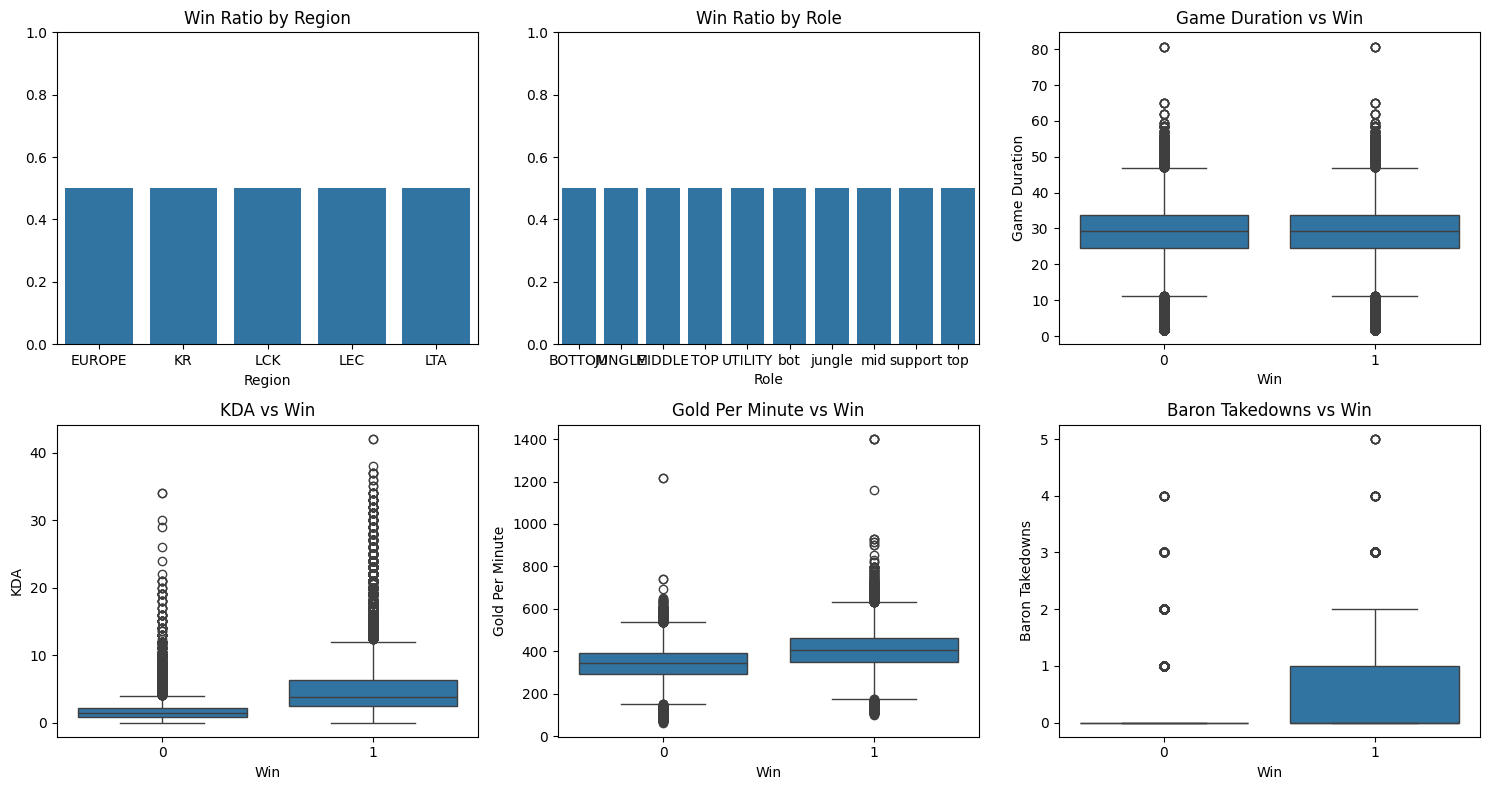

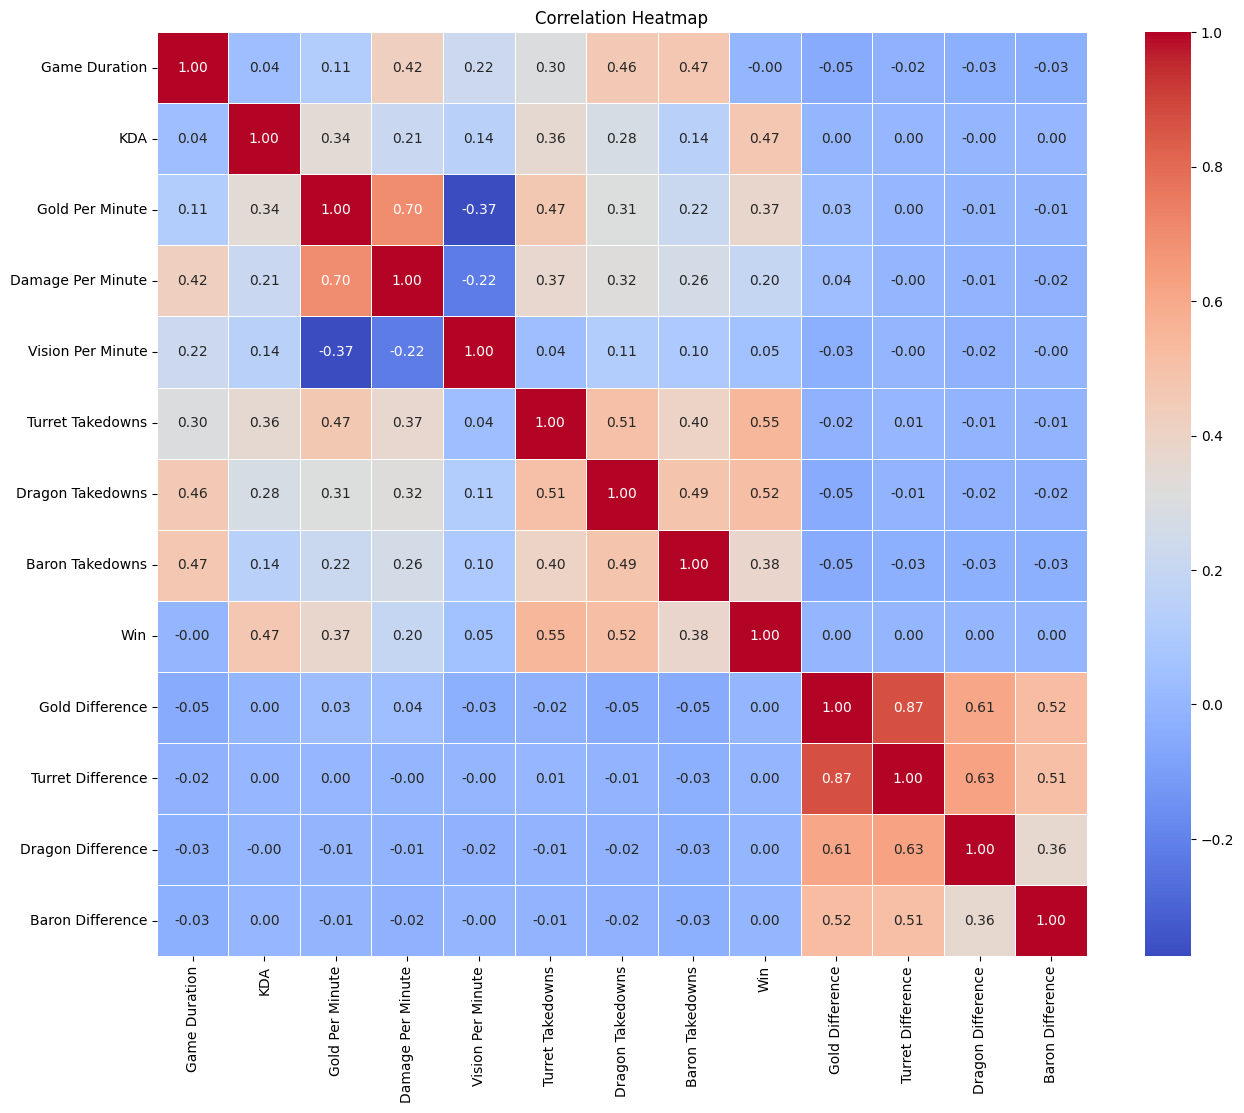

<Figure size 1200x800 with 0 Axes>

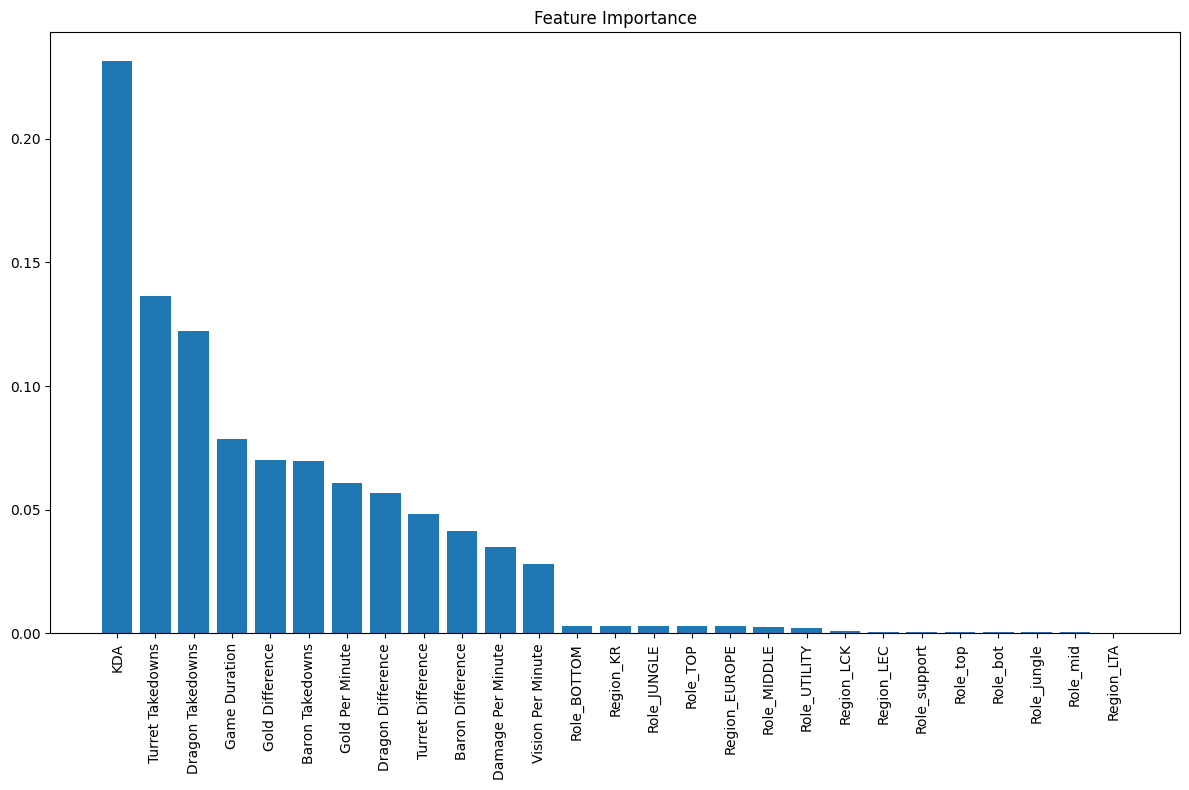

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8961
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12729
           1       0.90      0.89      0.90     12802

    accuracy                           0.90     25531
   macro avg       0.90      0.90      0.90     25531
weighted avg       0.90      0.90      0.90     25531



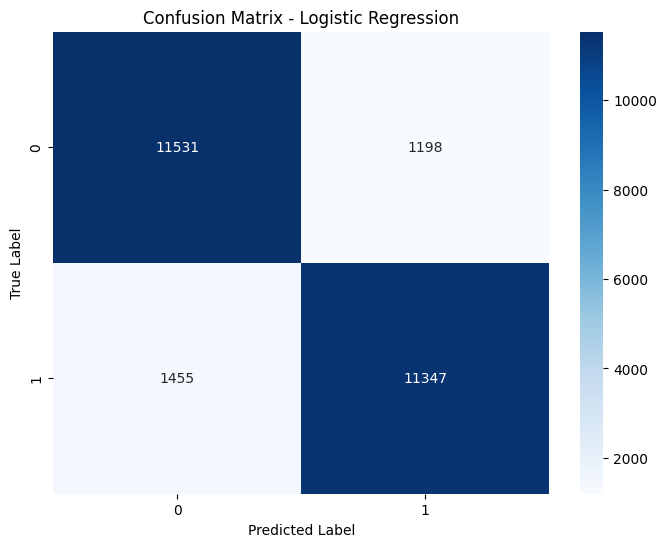

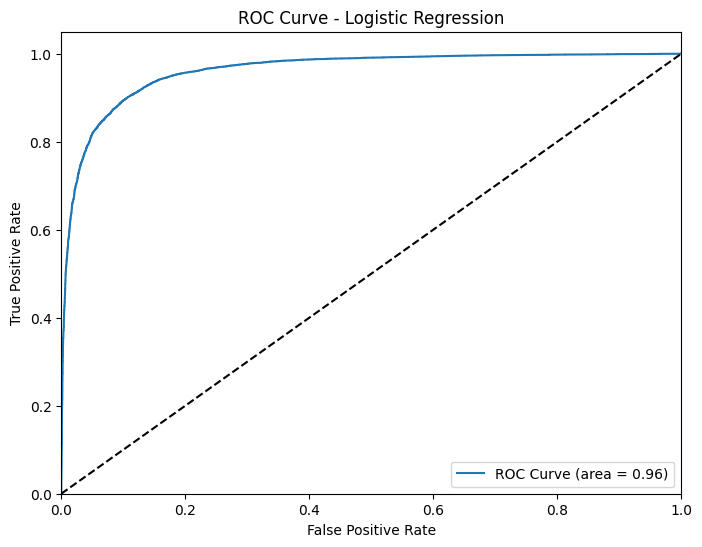

Training Random Forest...
Random Forest - Accuracy: 0.9461
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     12729
           1       0.94      0.95      0.95     12802

    accuracy                           0.95     25531
   macro avg       0.95      0.95      0.95     25531
weighted avg       0.95      0.95      0.95     25531



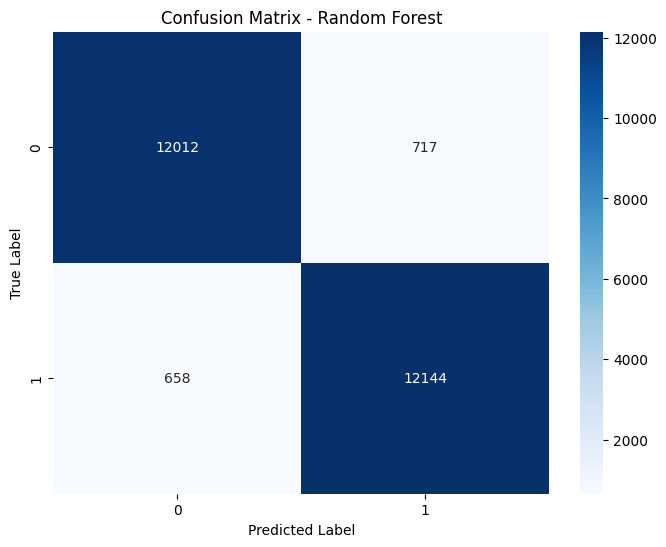

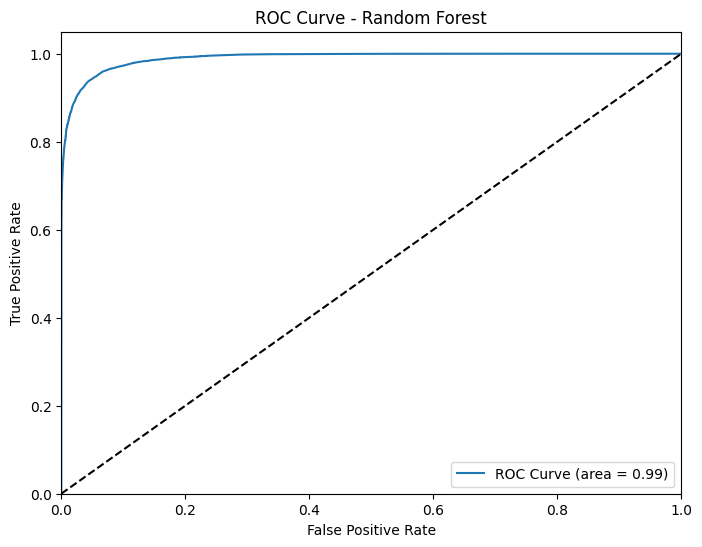

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9154
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     12729
           1       0.92      0.91      0.92     12802

    accuracy                           0.92     25531
   macro avg       0.92      0.92      0.92     25531
weighted avg       0.92      0.92      0.92     25531



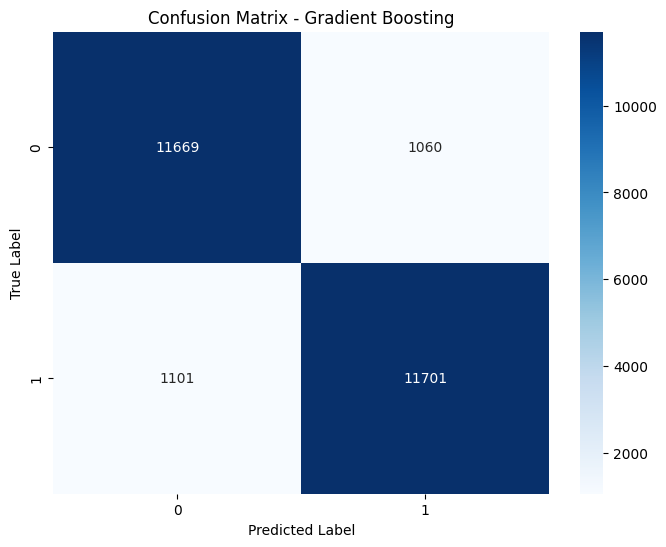

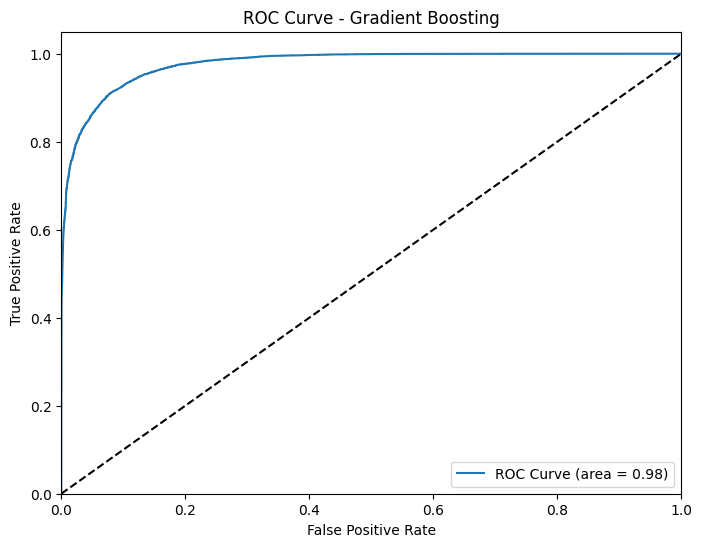

Training XGBoost...
XGBoost - Accuracy: 0.9588
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12729
           1       0.96      0.96      0.96     12802

    accuracy                           0.96     25531
   macro avg       0.96      0.96      0.96     25531
weighted avg       0.96      0.96      0.96     25531



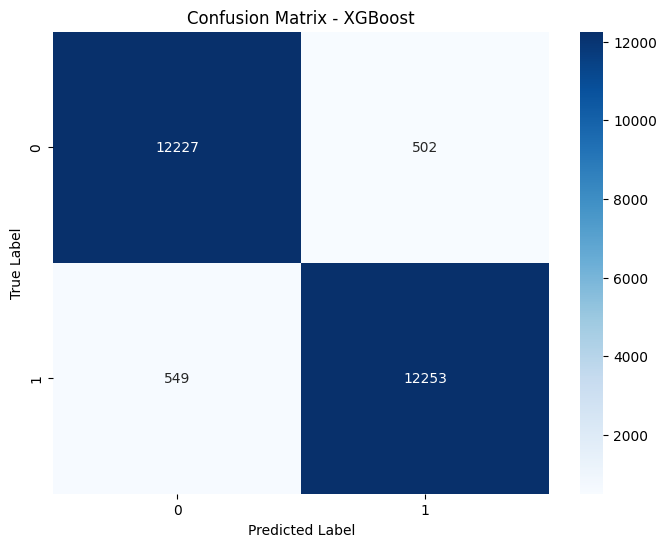

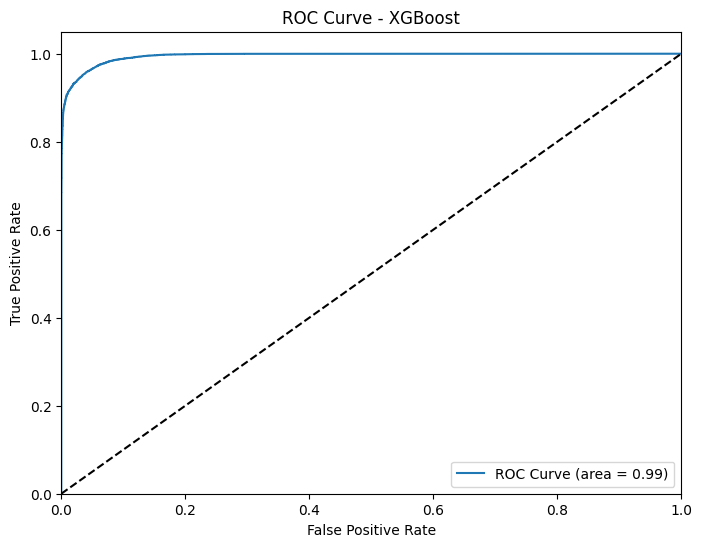

Training SVM...
SVM - Accuracy: 0.9489
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     12729
           1       0.96      0.94      0.95     12802

    accuracy                           0.95     25531
   macro avg       0.95      0.95      0.95     25531
weighted avg       0.95      0.95      0.95     25531



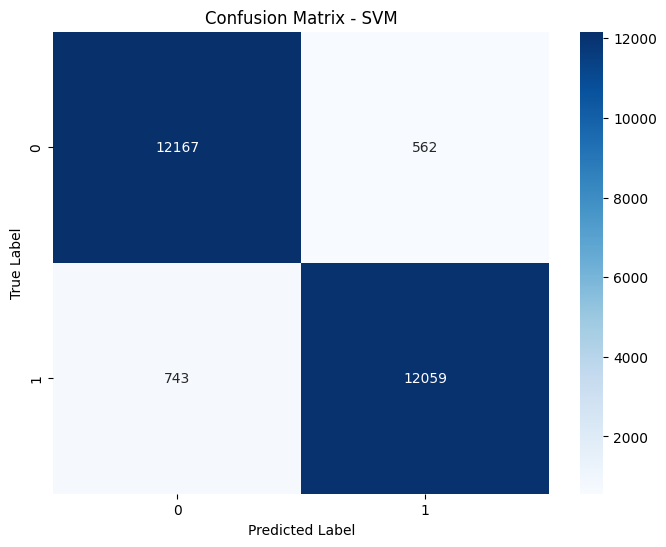

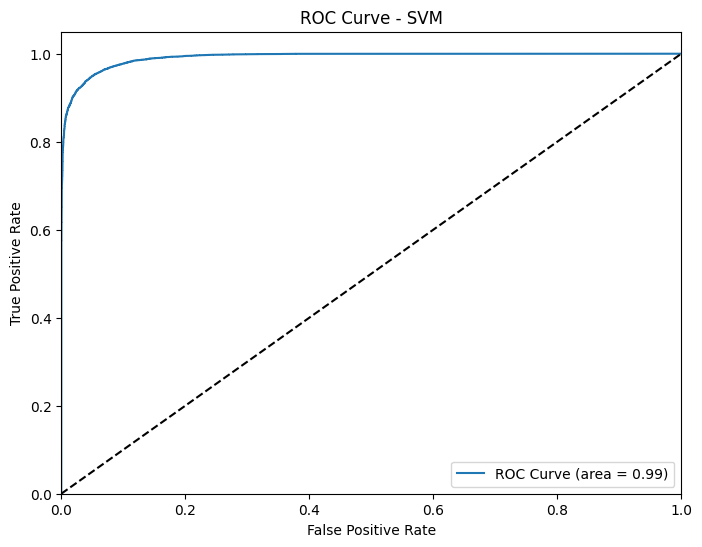

Training KNN...
KNN - Accuracy: 0.9425
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12729
           1       0.95      0.94      0.94     12802

    accuracy                           0.94     25531
   macro avg       0.94      0.94      0.94     25531
weighted avg       0.94      0.94      0.94     25531



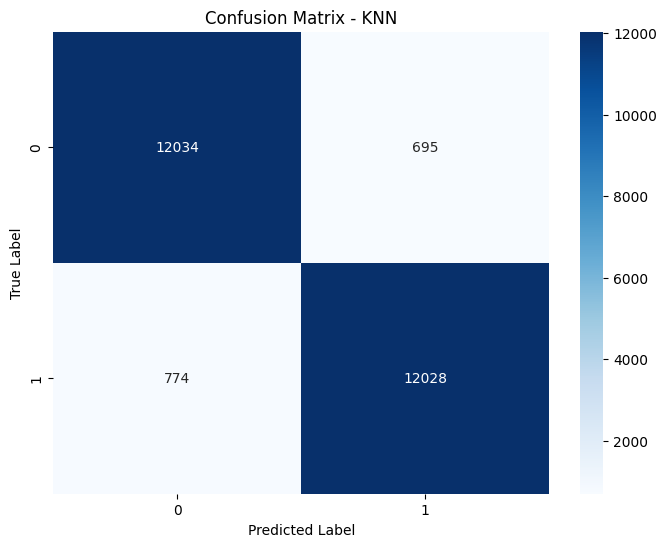

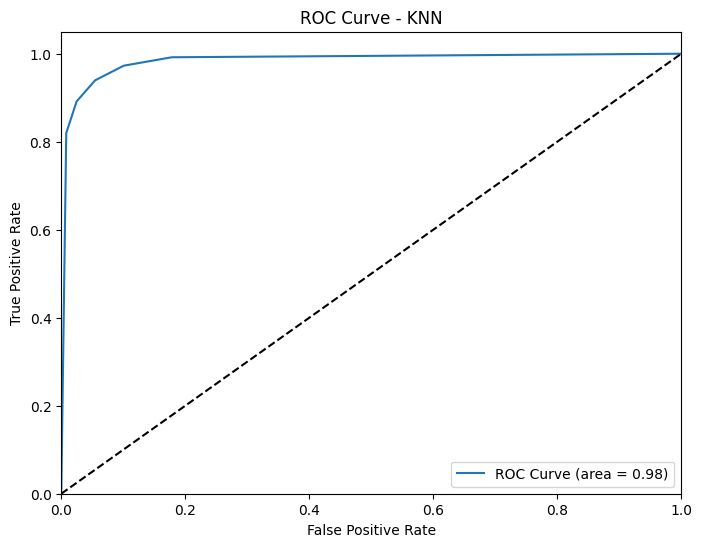

Training Decision Tree...
Decision Tree - Accuracy: 0.9276
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12729
           1       0.93      0.93      0.93     12802

    accuracy                           0.93     25531
   macro avg       0.93      0.93      0.93     25531
weighted avg       0.93      0.93      0.93     25531



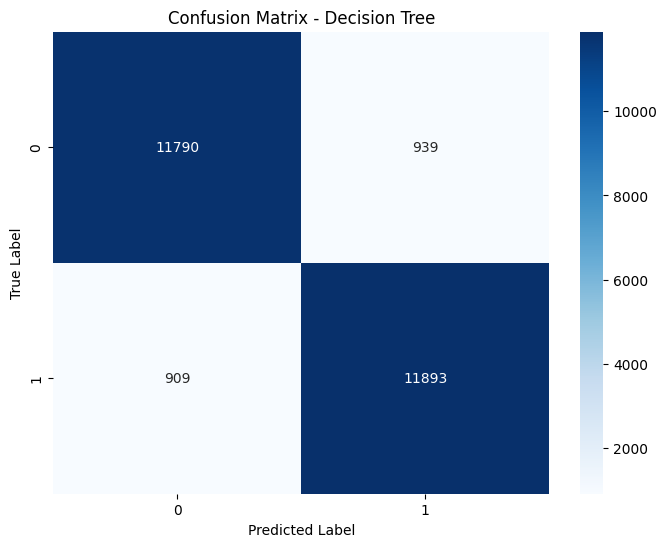

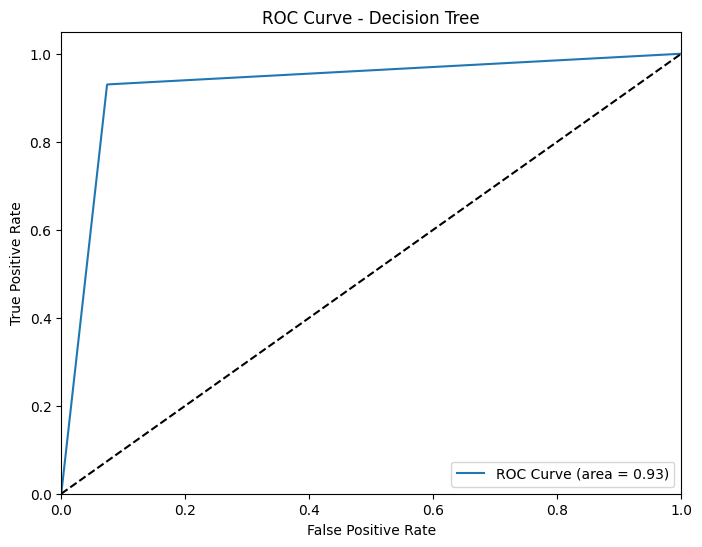

Training AdaBoost...
AdaBoost - Accuracy: 0.8736
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     12729
           1       0.89      0.85      0.87     12802

    accuracy                           0.87     25531
   macro avg       0.87      0.87      0.87     25531
weighted avg       0.87      0.87      0.87     25531



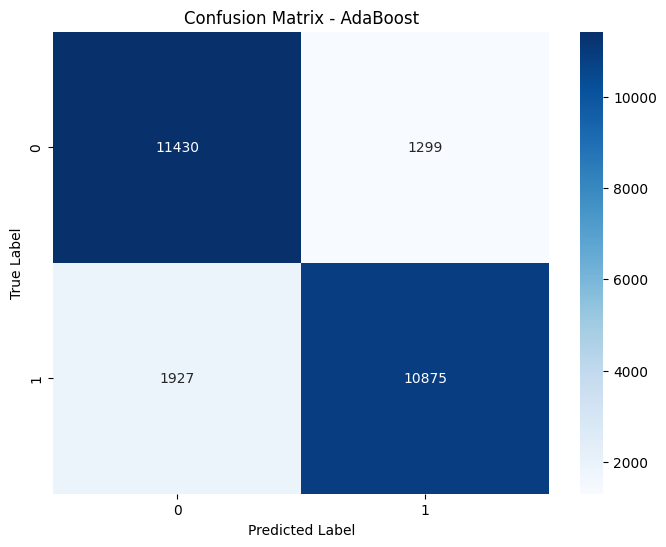

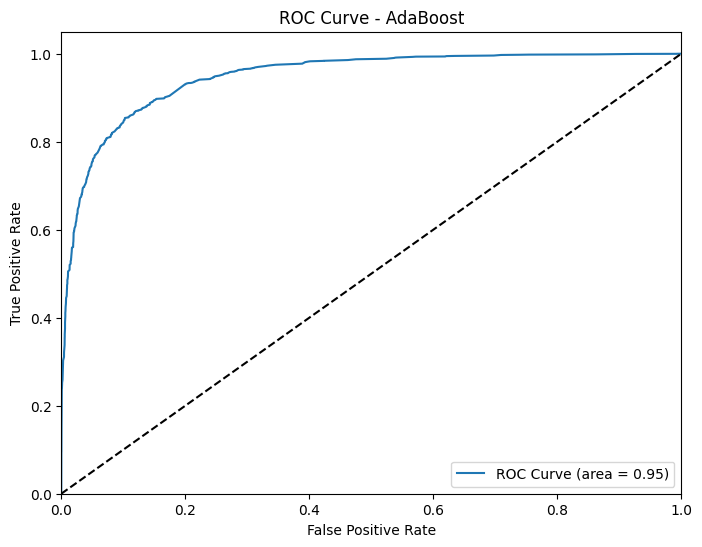

Training Neural Network...
Neural Network - Accuracy: 0.9619
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12729
           1       0.96      0.96      0.96     12802

    accuracy                           0.96     25531
   macro avg       0.96      0.96      0.96     25531
weighted avg       0.96      0.96      0.96     25531



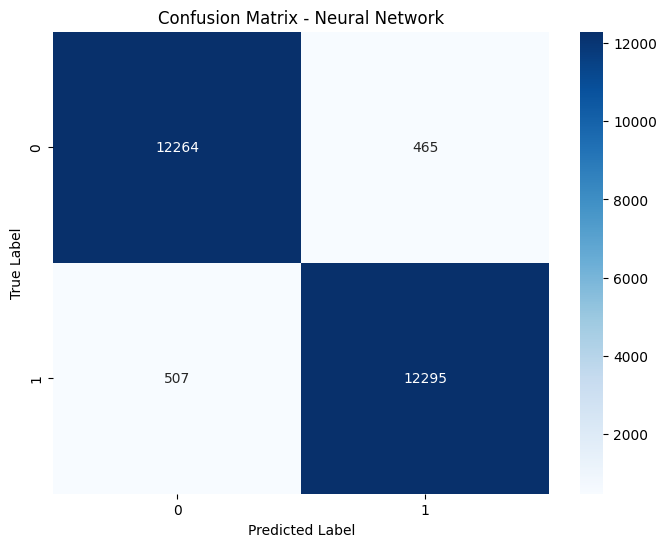

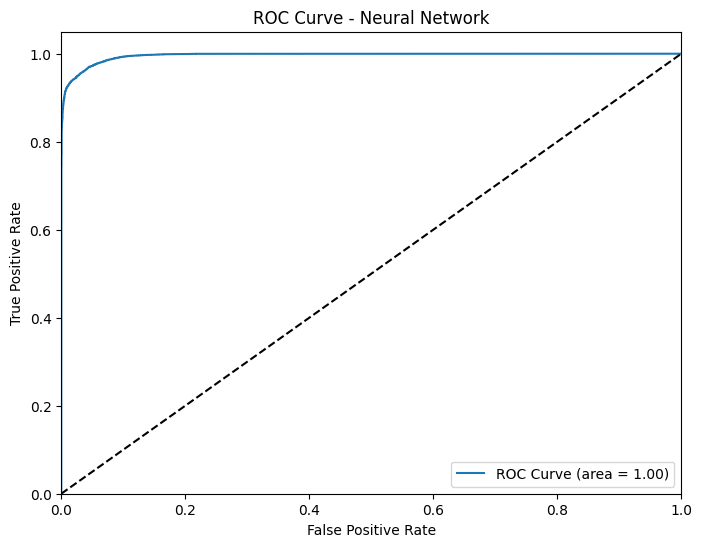

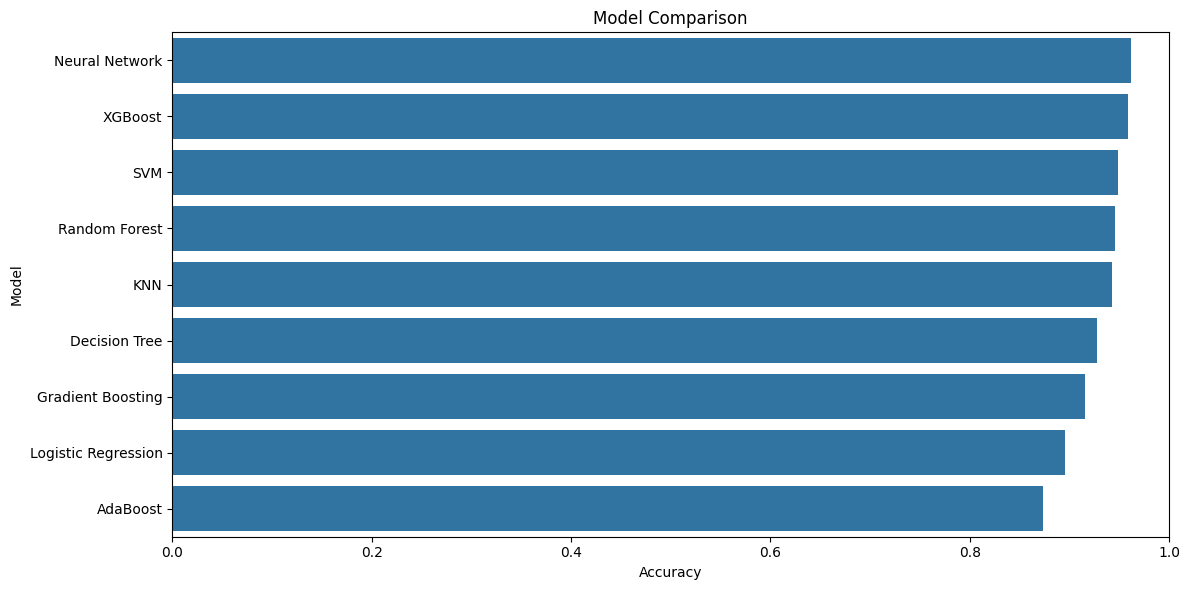

Performing hyperparameter tuning for Neural Network...
Best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant'}
Best cross-validation accuracy: 0.9610
Tuned model accuracy on test data: 0.9637
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12729
           1       0.97      0.95      0.96     12802

    accuracy                           0.96     25531
   macro avg       0.96      0.96      0.96     25531
weighted avg       0.96      0.96      0.96     25531

Model saved as 'lol_win_prediction_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

combined_df =  pd.read_csv("/content/drive/My Drive/combined_df.csv")

# Display basic information about the dataset
print("Dataset Shape:", combined_df.shape)
print("\nData Types:")
print(combined_df.dtypes)
print("\nMissing Values:")
print(combined_df.isnull().sum())
print("\nBasic Statistics:")
print(combined_df.describe())

# Exploratory Data Analysis
plt.figure(figsize=(15, 8))

# Win ratio by region
plt.subplot(231)
win_by_region = combined_df.groupby('Region')['Win'].mean()
sns.barplot(x=win_by_region.index, y=win_by_region.values)
plt.title('Win Ratio by Region')
plt.ylim(0, 1)

# Win ratio by role
plt.subplot(232)
win_by_role = combined_df.groupby('Role')['Win'].mean()
sns.barplot(x=win_by_role.index, y=win_by_role.values)
plt.title('Win Ratio by Role')
plt.ylim(0, 1)

# Game Duration vs Win
plt.subplot(233)
sns.boxplot(x='Win', y='Game Duration', data=combined_df)
plt.title('Game Duration vs Win')

# KDA vs Win
plt.subplot(234)
sns.boxplot(x='Win', y='KDA', data=combined_df)
plt.title('KDA vs Win')

# Gold Per Minute vs Win
plt.subplot(235)
sns.boxplot(x='Win', y='Gold Per Minute', data=combined_df)
plt.title('Gold Per Minute vs Win')

# Baron control vs Win
plt.subplot(236)
sns.boxplot(x='Win', y='Baron Takedowns', data=combined_df)
plt.title('Baron Takedowns vs Win')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(15, 12))
numerical_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
correlation = combined_df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Feature importance visualization with Random Forest
plt.figure(figsize=(12, 8))
X = combined_df.drop(['Match ID', 'Win'], axis=1)
y = combined_df['Win']

# Preprocessing
categorical_features = ['Region', 'Role']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [f for f in numerical_features if f not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

# Train a Random Forest model for feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_processed, y)

# Get feature names after one-hot encoding
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_features)

# Feature importance plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Prepare data for model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve (for models that support predict_proba)
    try:
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()
    except:
        print(f"ROC curve cannot be computed for {name}")

# Compare model performance
plt.figure(figsize=(12, 6))
models_df = pd.DataFrame({'Model': list(results.keys()), 'Accuracy': list(results.values())})
models_df = models_df.sort_values('Accuracy', ascending=False)
sns.barplot(x='Accuracy', y='Model', data=models_df)
plt.title('Model Comparison')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Hyperparameter tuning for the best model
best_model_name = models_df.iloc[0]['Model']
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs'],
        'classifier__penalty': ['l1', 'l2']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto', 0.1, 1]
    }
elif best_model_name == 'KNN':
    param_grid = {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }
elif best_model_name == 'Decision Tree':
    param_grid = {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'AdaBoost':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1]
    }
elif best_model_name == 'Neural Network':
    param_grid = {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__learning_rate': ['constant', 'adaptive']
    }

# Create the pipeline with the best model
best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned model accuracy on test data: {tuned_accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Save the best model for future use
import joblib
joblib.dump(best_pipeline, 'lol_win_prediction_model.pkl')

print("Model saved as 'lol_win_prediction_model.pkl'")

# Function to predict win probability for new matches
def predict_win_probability(model, new_data):
    """
    Predict win probability for new match data.

    Parameters:
    model: Trained pipeline model
    new_data: DataFrame with same features as training data

    Returns:
    DataFrame with input data and predicted win probability
    """
    # Check if new_data has the same features as training data
    required_cols = X.columns
    for col in required_cols:
        if col not in new_data.columns:
            new_data[col] = 0  # Fill missing columns with default value

    # Ensure columns are in the same order
    new_data = new_data[required_cols]

    # Predict win probability
    win_prob = model.predict_proba(new_data)[:, 1]

    # Add prediction to the data
    new_data['Win_Probability'] = win_prob

    return new_data

# Example usage of the prediction function
# sample_match = df.drop(['Match_ID', 'Win'], axis=1).sample(5)
# predictions = predict_win_probability(best_pipeline, sample_match)
# print(predictions[['Region', 'Role', 'KDA', 'Win_Probability']])

In [ ]:
acc_url = 'https://europe.api.riotgames.com/riot/account/v1/accounts/by-riot-id/lisianthus/xpp?api_key=RGAPI-1f6bbe71-3da3-4889-871b-66985dd113d2'

In [ ]:
puuid = "QNfthjypgj53nQek1eMYZ5wHuAYcOnk2AQPCbC3nnBmShyRR0ZDQSUgi3GgIkj9yf_B-1dL7ih65aA"

In [ ]:
match_url = 'https://europe.api.riotgames.com/lol/match/v5/matches/EUW1_7281506729?api_key=RGAPI-1f6bbe71-3da3-4889-871b-66985dd113d2'

In [ ]:
match_list = 'https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/QNfthjypgj53nQek1eMYZ5wHuAYcOnk2AQPCbC3nnBmShyRR0ZDQSUgi3GgIkj9yf_B-1dL7ih65aA/ids?type=ranked&start=0&count=100&api_key=RGAPI-1f6bbe71-3da3-4889-871b-66985dd113d2'

In [ ]:
game_no = 1
for match_ids in matches:
  print(game_no)
  print(match_ids)
  match_data = get_match_data(region, match_ids, api_key)
  part_index = match_data['metadata']['participants'].index(puuid)
  print(match_data['info']['participants'][part_index]['championName'])
  print("")
  game_no += 1

In [ ]:
get_puuid('europe', 'lisianthus', 'xpp', api_key)